# Group Chat

Group chat is a design pattern where a group of agents share a common thread
of messages: they all subscribe and publish to the same thread. Each participant
agent is specialized for a particular task, such as writer, illustrator, and editor
in a collaborative writing task.

The order
of converation is maintained by a Group Chat Manager agent, which selects
the next agent to speak. The exact algorithm for selecting the next agent
can vary based on your application requirements. Typicall, a round-robin
algorithm or a selection by an LLM model is used.

Group chat is useful for dynamically decomposing a complex task into smaller ones 
that can be handled by specialized agents with well-defined roles.

In this example, we implement a simple group chat system with a round-robin
Group Chat Manager to create content for a children's story book. 
We use three specialized agents: a writer, an illustrator, and an editor.

## Message Protocol

The message protocol for the group chat system is simple: user publishes
a `GroupChatMessage` message to all participants.
The group chat manager sends out a `RequestToSpeak` message to the next agent
in the round-robin order, and the agent publishes `GroupChatMessage` messages,
which are consumed by all participants.
Once a conclusion is reached, in this case, the editor approves the draft,
the group chat manager stops sending `RequestToSpeak` message, and
the group chat ends.

In [26]:
from autogen_core.components import Image
from autogen_core.components.models import LLMMessage
from pydantic import BaseModel


class GroupChatMessage(BaseModel):
    body: LLMMessage


class RequestToSpeak(BaseModel):
    pass

## Agents

Let's first define the agents that only uses LLM models to generate text.
The `WriterAgent` is responsible for writing a draft and create a description
for the illustration.
The `EditorAgent` is responsible for approving the draft which includes
both the text written by the `WriterAgent` and the illustration
created by the `IllustratorAgent`.

The participant agents' classes are all 
decorated with {py:meth}`~autogen_core.components.default_subscription`
to subscribe to the default topic type, and
each of them also decorated with {py:meth}`~autogen_core.components.type_subscription`
to subscribe to its own topic type.
This is because the group chat manager publishes a `RequestToSpeak` message
to the next agent's topic type, so to avoid the message being consumed by
other agents.

In [27]:
from typing import List

from autogen_core.base import MessageContext
from autogen_core.components import (
    DefaultTopicId,
    RoutedAgent,
    default_subscription,
    message_handler,
    type_subscription,
)
from autogen_core.components.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    SystemMessage,
    UserMessage,
)


@default_subscription
@type_subscription("writer")
class WriterAgent(RoutedAgent):
    def __init__(
        self,
        model_client: ChatCompletionClient,
    ) -> None:
        super().__init__("A writer")
        self._model_client = model_client
        self._chat_history: List[LLMMessage] = [
            SystemMessage(
                "You are a writer. Write a draft with a paragraph description of an illustration, starting the description paragraph with 'ILLUSTRATION'."
            )
        ]

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        self._chat_history.append(message.body)

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        completion = await self._model_client.create(self._chat_history)
        assert isinstance(completion.content, str)
        self._chat_history.append(AssistantMessage(content=completion.content, source="Writer"))
        print(f"\n{'-'*80}\nWriter:\n{completion.content}")
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=completion.content, source="Writer")), DefaultTopicId()
        )


@default_subscription
@type_subscription("editor")
class EditorAgent(RoutedAgent):
    def __init__(
        self,
        model_client: ChatCompletionClient,
    ) -> None:
        super().__init__("An editor")
        self._model_client = model_client
        self._chat_history: List[LLMMessage] = [
            SystemMessage("You are an editor. Reply with 'APPROVE' to approve the draft")
        ]

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        self._chat_history.append(message.body)

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        completion = await self._model_client.create(self._chat_history)
        assert isinstance(completion.content, str)
        self._chat_history.append(AssistantMessage(content=completion.content, source="Editor"))
        print(f"\n{'-'*80}\nEditor:\n{completion.content}")
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=completion.content, source="Editor")), DefaultTopicId()
        )

Now let's define the `IllustratorAgent` which uses a DALL-E model to generate
an illustration based on the description provided by the `WriterAgent`.

In [28]:
import re

import openai
from IPython.display import display


@default_subscription
@type_subscription("illustrator")
class IllustratorAgent(RoutedAgent):
    def __init__(self, image_client: openai.AsyncClient) -> None:
        super().__init__("An illustrator")
        self._image_client = image_client
        self._chat_history: List[LLMMessage] = []

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        self._chat_history.append(message.body)

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        # Generate an image using dall-e-2
        last_message_text = self._chat_history[-1].content
        assert isinstance(last_message_text, str)
        match = re.search(r"ILLUSTRATION(.+)\n", last_message_text, re.DOTALL)
        print(f"\n{'-'*80}\nIllustrator:\n")
        if match is None:
            print("No description found")
            await self.publish_message(
                GroupChatMessage(body=UserMessage(content="No description found", source="Illustrator")),
                DefaultTopicId(),
            )
            return
        description = match.group(1)[:500]
        print(description.strip())
        response = await self._image_client.images.generate(
            prompt=description.strip(), model="dall-e-2", response_format="b64_json", size="256x256"
        )
        image = Image.from_base64(response.data[0].b64_json)  # type: ignore
        display(image.image)  # type: ignore
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=[image], source="Illustrator")), DefaultTopicId()
        )

Lastly, we define the `GroupChatManager` agent which manages the group chat
and selects the next agent to speak in a round-robin fashion.
The group chat manager checks if the editor has approved the draft by 
looking for the "APPORVED" keyword in the message. If the editor has approved
the draft, the group chat manager stops selecting the next speaker, and the group chat ends.

The group chat manager subscribes to only the default topic type because
all participants publish to the default topic type only. However, the group chat manager
publishes `RequestToSpeak` messages to the next agent's topic type,
thus the group chat manager's constructor takes a list of agents' topic types
as an argument.

In [29]:
@default_subscription
class GroupChatManager(RoutedAgent):
    def __init__(self, participant_topic_types: List[str]) -> None:
        super().__init__("Group chat manager")
        self._num_rounds = 0
        self._participant_topic_types = participant_topic_types
        self._chat_history: List[GroupChatMessage] = []

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        self._chat_history.append(message)
        assert isinstance(message.body, UserMessage)
        if message.body.source == "Editor" and "APPROVE" in message.body.content:
            return
        speaker_topic_type = self._participant_topic_types[self._num_rounds % len(self._participant_topic_types)]
        self._num_rounds += 1
        await self.publish_message(RequestToSpeak(), DefaultTopicId(type=speaker_topic_type))

## Running the Group Chat

To run the group chat, we create an {py:class}`~autogen_core.application.SingleThreadedAgentRuntime`
and register the agents' factories and subscriptions.
We then start the runtime and publish a `GroupChatMessage` to start the group chat.


--------------------------------------------------------------------------------
Writer:
**ILLUSTRATION:** The scene captures a majestic dragon perched on the rugged cliffs of a towering mountain. Its scales shimmer with iridescent hues of emerald, sapphire, and gold, reflecting the light of a setting sun. The dragon's wings are spread wide, made of a delicate, translucent membrane that seems to catch the colors of the sky—fiery reds, oranges, and cool purples. The creature’s eyes glint with ancient wisdom and a touch of mischief, while smoke curls lazily from its nostrils. Below, a lush, green valley stretches out, dotted with medieval villages, castles, and winding rivers. Tall trees frame the edges of the illustration, their leaves rustling in the gentle breeze.

**Poem:**

In twilight's glow on mountain high,
The dragon reigns, near touching sky.
With scales that court each fleeting ray,
A living gem at end of day.

Wings unfurled in sunset's blaze,
Reflective of night's softest h

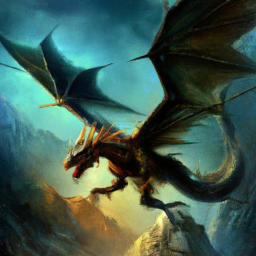


--------------------------------------------------------------------------------
Editor:
APPROVE


In [30]:
from autogen_core.application import SingleThreadedAgentRuntime
from autogen_core.components.models import OpenAIChatCompletionClient

runtime = SingleThreadedAgentRuntime()

await EditorAgent.register(
    runtime,
    "editor",
    lambda: EditorAgent(
        OpenAIChatCompletionClient(
            model="gpt-4o",
            # api_key="YOUR_API_KEY",
        )
    ),
)
await WriterAgent.register(
    runtime,
    "writer",
    lambda: WriterAgent(
        OpenAIChatCompletionClient(
            model="gpt-4o",
            # api_key="YOUR_API_KEY",
        )
    ),
)
await IllustratorAgent.register(
    runtime,
    "illustrator",
    lambda: IllustratorAgent(
        openai.AsyncClient(
            # api_key="YOUR_API_KEY",
        )
    ),
)
await GroupChatManager.register(
    runtime,
    "group_chat_manager",
    lambda: GroupChatManager(
        participant_topic_types=["writer", "illustrator", "editor"],
    ),
)

runtime.start()
await runtime.publish_message(
    GroupChatMessage(
        body=UserMessage(content="Please write a short poem about a dragon with illustration.", source="User")
    ),
    DefaultTopicId(),
)
await runtime.stop_when_idle()

From the output, you can see the writer, illustrator, and editor agents
taking turns to speak and collaborate to generate a poem with an illustration.